# Clean Audio - Exploration

Here we explore existing models that could be used with little to no changes.

## Project

We intend to create a system that can generate high-resolution, clean voice from a low-resolution sample.
Simulate the high-quality recording studios using phone microphones.

## To Try

* Explore PyTorch's speech brain framework
* DiffWave
* NU-Wave
* (maybe) U-Net based implementation

# Ideas

The ideas below aren't necessarily mutually exclusive.

## Diffuse Model

Treat the problem as a denoise step in a Diffuse Model Architecture where the objective is to predict the next step in denoising.  
The number of steps would be a hyper-parameter.

The idea is to start with high-res audio and train by adding noise progressively, similar to how Diffuse Image models are trained.  
This model architecture seems to fit the problem well.

Q: I don't yet understand how this architecture keeps consistency along time dimension (is this where auto-regressive comes up?)

Look into:
* WaveNet
* DiffWave
* NU-Wave

## Speech Synthesis from Speech

Treat the problem as speech synthesis where the input is low-res audio and we're synthethising the hi-res version.  
I don't know much about these architectures. Just a high-level idea at the moment.  

Potential routes:
* Use PyTorch Tacotron 2 model and fine-tune with a different tail (inputs) of the model

# PyTorch

## Generating Speech with Tacotron 2

Source: https://pytorch.org/hub/nvidia_deeplearningexamples_tacotron2/

In [3]:
# Setup environment
!pip install numpy scipy librosa unidecode inflect librosa
!apt-get update
!apt-get install -y libsndfile1

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 235 kB 18.6 MB/s eta 0:00:01
Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1194 kB]
Get:6 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1834 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [874 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.2 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updat

In [18]:
import torch

In [19]:
# Load and setup the model to generate Spectograms
tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/Classification/ConvNets/image_classification/models/efficientnet.py:17: UserWarning: pytorch_quantization module not found, quantization will not be available
  warnings.warn(


Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [20]:
# Setup the tool to generate audio wave from spectogram
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow = waveglow.to('cuda')
waveglow.eval()

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [21]:
text = "I went for a run today"

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
sequences, lengths = utils.prepare_input_sequence([text])

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [22]:
with torch.no_grad():
    mel, _, _ = tacotron2.infer(sequences, lengths)
    audio = waveglow.infer(mel)
audio_numpy = audio[0].data.cpu().numpy()
rate = 22050

In [23]:
from IPython.display import Audio
Audio(audio_numpy, rate=rate)

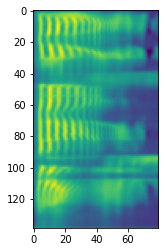

In [31]:
import matplotlib.pyplot as plt
plt.imshow(mel.cpu().permute(2, 1, 0))

In [14]:
# Save audio file
from scipy.io.wavfile import write
write("data/audio/synth_voice.wav", rate, audio_numpy)

In [15]:
# Save spectogram
torch.save(mel, "data/spectograms/synth_voice_spec.pt")

## DiffWave

Source: https://github.com/lmnt-com/diffwave

### Notes

This is a vocoder, useful for when a spectogram already exists. It could be considered the end of the network or directly used as a pre-trained end.

In [5]:
!pip install --upgrade /diffwave/.

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Processing /diffwave
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for diffwave: filename=diffwave-0.1.8-py3-none-any.whl size=19076 sha256=de4e2339d94a1abac97a8dd8c2e0bef0c2a3c271f60efcbc35edad98f1cf8965
  Stored in directory: /tmp/pip-ephem-wheel-cache-ii7f4_lz/wheels/cf/88/7a/7bed3d92cc884df4c1bd5372ccb240d973a95ef3dca72143ae
Successfully built diffwave
  Attempting uninstall: diffwave
    Found existing installation: diffwave 0.1.8
    Uninstalling diffwave-0.1.8:
      Successfully uninstalled diffwave-0.1.8


In [1]:
import torch
import numpy as np

In [4]:
from diffwave.inference import predict as dwave_predict

model_dir = "models/diffwave-ljspeech-22kHz-1000578.pt"

In [3]:
# Load or create data

from diffwave.preprocess import transform
transform("data/audio/synth_voice.wav")
spectogram = torch.from_numpy(np.load("data/audio/synth_voice.wav.spec.npy"))

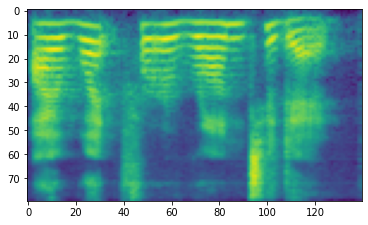

In [4]:
import matplotlib.pyplot as plt
plt.imshow(spectogram)

In [26]:
audio, sample_rate = dwave_predict(spectogram, model_dir, fast_sampling=True)

In [27]:
from IPython.display import Audio
Audio(audio.data.cpu(), rate=sample_rate)

In [17]:
import torchaudio as taudio
audio, sr = taudio.load("data/audio/synth_voice.wav")
Audio(audio, rate=sr)

# Study

## Spectograms

Understand what they are and how to work with them.

Source: https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

In [1]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
# Load the signal
audio, sample_rate = librosa.load("data/audio/synth_voice.wav")

Text(0, 0.5, 'Amplitude')

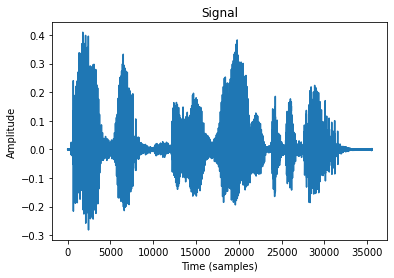

In [3]:
plt.plot(audio)
plt.title("Signal")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")

/tmp/ipykernel_108/464870992.py:5: UserWarning: n_fft=2048 is too small for input signal of length=512
  fourier = np.abs(librosa.stft(audio[:n_fft], hop_length = n_fft+1))


Text(0, 0.5, 'Amplitude')

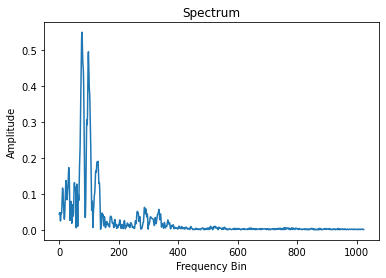

In [17]:
import numpy as np

# Spectrum (FFT)
n_fft = 512 # 512 better for speech and 2048 (default) better for music, this should probably be a hyper-parameter
fourier = np.abs(librosa.stft(audio[:n_fft], hop_length = n_fft+1))

plt.plot(fourier)
plt.title("Spectrum")
plt.xlabel("Frequency Bin")
plt.ylabel("Amplitude")

Text(0.5, 1.0, 'Spectogram')

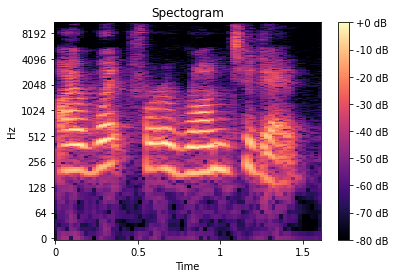

In [28]:
# Create the spectogram
spec = np.abs(librosa.stft(audio, hop_length=n_fft))
spec = librosa.amplitude_to_db(spec, ref=np.max) # ref here gets the max of all values, normalising the spectogram

librosa.display.specshow(spec, sr=sample_rate, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectogram")

Text(0.5, 1.0, 'Mel Spectogram')

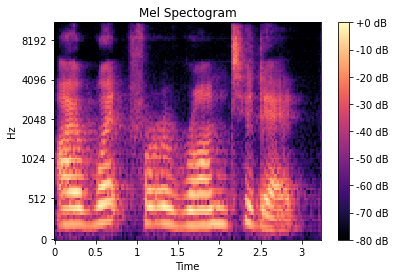

In [32]:
# Create the mel spectogram
spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate, n_fft=n_fft, hop_length=n_fft // 2)
spec = librosa.power_to_db(spec, ref=np.max)

librosa.display.specshow(spec, sr=sample_rate, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Mel Spectogram")

In [ ]:
from PIL import Image
